In [1]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.dates as mdates
from datetime import time
xformatter = mdates.DateFormatter('%H:%M')  # for time axis plots

%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
style.use('seaborn-whitegrid')

from sklearn.model_selection import KFold
from pandas.tseries.frequencies import to_offset
from pickle import load,dump
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_regression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Bidirectional
from keras.callbacks import EarlyStopping
from geneticalgorithm import geneticalgorithm as ga
from keras.backend import clear_session
import warnings
warnings.filterwarnings('ignore')

In [2]:
ORMAT_TIME='%Y-%m-%d %H:%M:%S'
START_TIME_DAY = time(5,0,0)
END_TIME_DAY = time(18,30,0)
TIME_1_STEP = 15 # minute
step_lag_1_day = 24*60//TIME_1_STEP
steps_2hours = 60*2//TIME_1_STEP

In [3]:
activation_list = ['linear','relu', 'tanh','sigmoid']
optimizer_list = ['adam', 'rmsprop', 'sgd', 'adamax']
range_neurons = [8,100]
selectors = []
algorithm_param = {
    'max_num_iteration': 5,
    'population_size': 5,
    'mutation_probability': 0.1,
    'elit_ratio': 0.2,
    'crossover_probability': 0.5,
    'parents_portion': 0,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 2
}

In [4]:
# Nhap du lieu train data
def import_train_data(path_file_train):
    df = pd.read_csv(path_file_train)
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp']
                                      )
    df = df.set_index('TimeStamp')
    return df

In [5]:
def resample_df(df, resample_time, time_col='TimeStamp'):
    """
    resample_time: `minute`
    """
    resample_df = df.copy()
    if resample_time >= 30:
        resample_df = resample_df.set_index(
            resample_df[time_col] - to_offset(str(resample_time//2)+"min"))
    resample_df = resample_df.resample(str(resample_time)+'min', label='right').mean()
    return resample_df

In [6]:
all_plant = import_train_data('./LN2_training.csv')
# all_plant = all_plant.reset_index()
all_plant = resample_df(all_plant, resample_time = 15, time_col='TimeStamp')

In [7]:
# Split train, val data theo ti le 8/2
def train_valid_split(df, split_ratio=[0.8, 0.2]):
    train_ratio, valid_ratio = split_ratio
    assert train_ratio + valid_ratio  == 1.0
    n_df = len(df)
    # Train / Validation  Split
    train_split = int(n_df * train_ratio)
    valid_split = int(n_df * (train_ratio + valid_ratio))

    train = df[:train_split]
    val = df[train_split:valid_split]

    print(f'Train set: {len(train)} ')
    print(f'Validation set: {len(val)} ')

    return train, val 

In [8]:
def num_step_1hour(df):
    """
    Get number step of 1 hours
    """
    step_hours = None
    if type(df.index) == pd.core.indexes.datetimes.DatetimeIndex:
        time_1step = int((df.index[1] - df.index[0]) /
                         np.timedelta64(1, 'm'))  # minute
        step_hours = 60 // time_1step
    return step_hours

In [9]:
def make_data_supervised(dt, num_pre_around=5, num_day_pre=3):
    step_lag_1_day = num_step_1hour(dt)*24
    dt_lag = pd.DataFrame()
    for col in dt.columns:
        for day_pre in range(num_pre_around+1):
            if day_pre == 0:
                dt_lag[col+'(t)'] = dt[col]
            else:
                dt_lag[col+'(t-'+str(day_pre)+')'] = dt[col].shift(day_pre)
        for day_pre in range(1, num_day_pre):
            step_lag = step_lag_1_day*day_pre
            for lag in range(num_pre_around+1):
                dt_lag[col+'(t-'+str(step_lag+lag) +
                       ')'] = dt[col].shift(step_lag+lag)
                dt_lag[col+'(t-'+str(step_lag-lag) +
                       ')'] = dt[col].shift(step_lag-lag)
    dt_lag = dt_lag.dropna()
    dt_lag['hour'] = dt_lag.index.hour
    dt_lag['day'] = dt_lag.index.day
    dt_lag['day_of_week'] = dt_lag.index.dayofweek
    dt_lag['month'] = dt_lag.index.month
    dt_lag['day_of_year'] = dt_lag.index.dayofyear
    return dt_lag

In [10]:
def select_Kbest(train,score_f):
    X_select = train[train.columns[1:]]
    y_select = train['TotW(t)']
    bestfeatures = SelectKBest(score_func=score_f, k='all')
    fit = bestfeatures.fit(X_select,y_select)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_select.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  
    featureScores = featureScores.sort_values(by='Score', ascending=False)

    return featureScores

In [11]:
def GA_result(ga_model):
    best_neurons = (int(ga_model.best_variable[0]))
    best_activation = (int(ga_model.best_variable[1]))
    best_optimizer = (int(ga_model.best_variable[2]))
    return {
        'activations': activation_list[best_activation],
        'optimizers': optimizer_list[best_optimizer],
        'neurons': best_neurons,
        'num_feature': int(ga_model.best_variable[3])
    }

In [12]:
def get_or_create_path(path):
    if os.path.isdir(path) is False:
        os.mkdir(path)

In [26]:
def scale_func(train, path_scale):
    get_or_create_path(path_scale)
    train_scale_df = pd.DataFrame(index=train.index)
    # val_scale_df = pd.DataFrame(index=val.index)
    
    for col in train.columns:
        scaler = MinMaxScaler()
        train_scale_df[col] = scaler.fit_transform(train[col].values.reshape(-1,1))[:,0]
        # val_scale_df[col] = scaler.transform(val[col].values.reshape(-1,1))[:,0]
        pickle.dump(scaler, open(path_scale + col+'.pkl','ab+'))
    return train_scale_df

In [28]:
data_scale = scale_func(all_plant, './LN2/Cross_validation/')
data_super_vised = make_data_supervised(data_scale)


In [15]:
data_X, data_y = data_scale.values[:, 1:], data_scale.values[:, :1]



In [16]:
train_X_ = data_X.reshape(data_X.shape[0], 1, data_X.shape[1])

In [17]:
def evaluate(gene):
    g = [int(i) for i in gene]
    train_X_eval = train_X_.copy()
    train_y_eval = data_y.copy()
    selector = SelectKBest(score_func=f_regression, k=g[3])
    train_X_eval = train_X_eval.reshape(train_X_eval.shape[0], train_X_eval.shape[2])
    train_X_eval = selector.fit_transform(train_X_eval, train_y_eval)
    train_X_eval = train_X_eval.reshape(train_X_eval.shape[0],1,train_X_eval.shape[1])
    
    neurons = g[0]
    activation = activation_list[g[1]]
    optimizer = optimizer_list[g[2]]
    
    print('\nNumber of neurons: ', neurons,
        ', activation function: ', activation,
        ', optimizer function: ', optimizer,
        ', features: ', g[3])

    clear_session()
    model = Sequential()

    model.add(Bidirectional(LSTM(neurons, activation=activation, 
                                    input_shape=(train_X_eval.shape[1], train_X_eval.shape[2]),
                                    return_sequences=True)))
    
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer)

    history = model.fit(train_X_eval, train_y_eval, validation_split=0.2,
                callbacks = EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True), 
                epochs=100, batch_size=50, verbose=0,shuffle=False)
    print('val_loss: ', min(history.history['val_loss']))
    return min(history.history['val_loss'])

In [18]:
varbound = np.array([range_neurons, [0, 3], [0, 3], [1, train_X_.shape[2]]])
ga_model = ga(function=evaluate,
            dimension=4,
            variable_type='int',
            function_timeout=10000,
            variable_boundaries=varbound,
            convergence_curve=False,
            algorithm_parameters=algorithm_param)
ga_model.run()


Number of neurons:  97 , activation function:  sigmoid , optimizer function:  adamax , features:  7
val_loss:  0.010917727835476398

Number of neurons:  46 , activation function:  sigmoid , optimizer function:  rmsprop , features:  59
val_loss:  0.01345650851726532

Number of neurons:  29 , activation function:  linear , optimizer function:  sgd , features:  10
val_loss:  0.010906628333032131

Number of neurons:  66 , activation function:  sigmoid , optimizer function:  sgd , features:  57
val_loss:  0.019619207829236984

Number of neurons:  49 , activation function:  tanh , optimizer function:  sgd , features:  43
val_loss:  0.011133668944239616
||||||||||________________________________________ 20.0% GA is running...
Number of neurons:  29 , activation function:  linear , optimizer function:  sgd , features:  10
val_loss:  0.01099269650876522

Number of neurons:  85 , activation function:  linear , optimizer function:  sgd , features:  10
val_loss:  0.011460507288575172

Number of n

In [19]:
def GA_result(ga_model):
    best_neurons = (int(ga_model.best_variable[0]))
    best_activation = (int(ga_model.best_variable[1]))
    best_optimizer = (int(ga_model.best_variable[2]))
    return {
        'activations': activation_list[best_activation],
        'optimizers': optimizer_list[best_optimizer],
        'neurons': best_neurons,
        'num_feature': int(ga_model.best_variable[3])
    }

In [20]:
ga_result = GA_result(ga_model)

In [33]:
col_analysis = list(data_super_vised)
featureScores = select_Kbest(data_super_vised[col_analysis],f_regression)
best_feature = list(featureScores['Specs'][:ga_result['num_feature']])
pickle.dump(best_feature, open('./LN2/Cross_validation/' + 'best_feature.pkl','wb'))

In [22]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True)

In [23]:
# Lay data co best_feature truoc khi dua vao cross-validation
data_split_feature = data_scale[['TotW(t)']+best_feature]
data_X_feature, data_y_feature = data_split_feature.values[:, 1:], data_split_feature.values[:, :1]

In [24]:
def make_model(train, val, ga_result):
    train_X = train.copy()
    train_y = val.copy()

    model = Sequential()
    model.add(
        Bidirectional(LSTM(ga_result['num_feature'],
             activation=ga_result['activations'],
             input_shape=(train_X.shape[1], train_X.shape[2])),merge_mode= 'ave'))
    model.add(Dense(1))
    model.compile(loss='mae',
                  optimizer=ga_result['optimizers'],
                  metrics=['mse', 'mae', 'cosine_proximity'])
    # fit network
    history = model.fit(train_X,
                        train_y,
                        epochs=100,
                        batch_size=50,
                        validation_data=(val_X, val_y),
                        verbose=1,
                        shuffle=False,
                        callbacks=EarlyStopping(monitor='val_loss',
                                                patience=15,
                                                restore_best_weights=True))
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.suptitle('Loss', y=0.93)
    ax.plot(history.history['mae'], label='train')
    ax.plot(history.history['val_mae'], label='val')
    ax.set_title('mae')
    ax.legend(loc='upper right')
    return model


Epoch 1/100
793/793 [==============================] - 7s 5ms/step - loss: 0.0808 - mse: 0.0268 - mae: 0.0808 - cosine_proximity: 0.5249 - val_loss: 0.0415 - val_mse: 0.0061 - val_mae: 0.0415 - val_cosine_proximity: 0.5528
Epoch 2/100
793/793 [==============================] - 3s 4ms/step - loss: 0.0382 - mse: 0.0052 - mae: 0.0382 - cosine_proximity: 0.5501 - val_loss: 0.0360 - val_mse: 0.0046 - val_mae: 0.0360 - val_cosine_proximity: 0.5528
Epoch 3/100
793/793 [==============================] - 3s 4ms/step - loss: 0.0322 - mse: 0.0037 - mae: 0.0322 - cosine_proximity: 0.5502 - val_loss: 0.0296 - val_mse: 0.0033 - val_mae: 0.0296 - val_cosine_proximity: 0.5528
Epoch 4/100
793/793 [==============================] - 3s 4ms/step - loss: 0.0266 - mse: 0.0027 - mae: 0.0266 - cosine_proximity: 0.5500 - val_loss: 0.0246 - val_mse: 0.0024 - val_mae: 0.0246 - val_cosine_proximity: 0.5524
Epoch 5/100
793/793 [==============================] - 2s 3ms/step - loss: 0.0228 - mse: 0.0021 - mae: 0.022

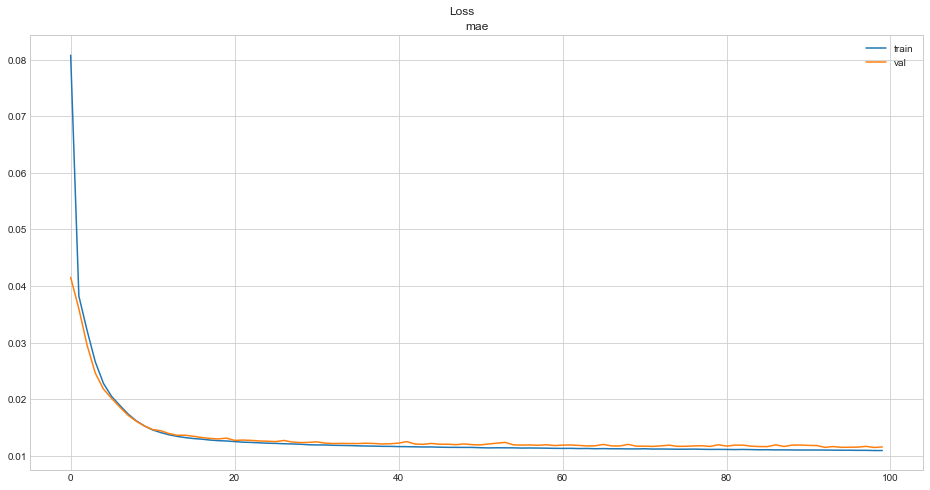

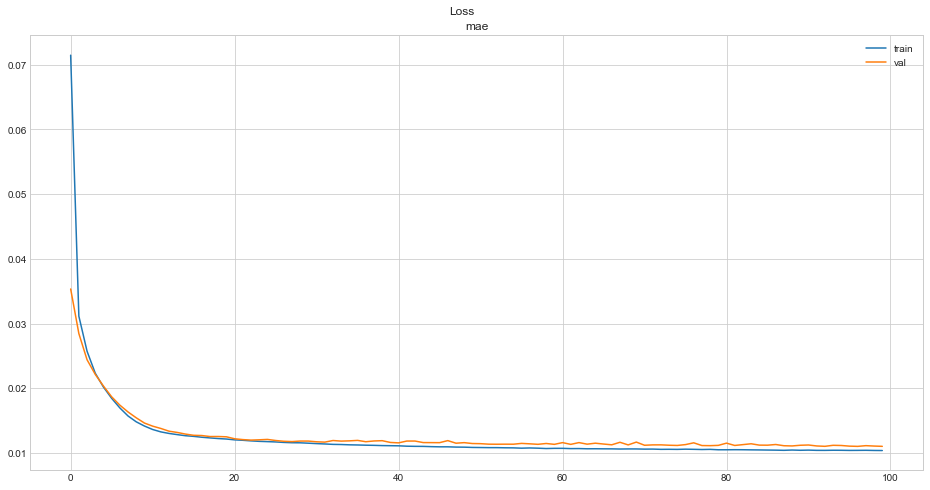

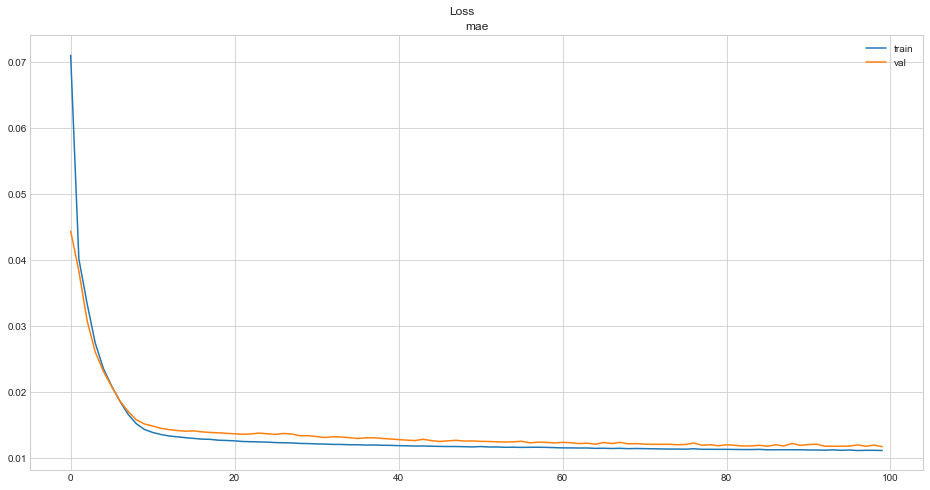

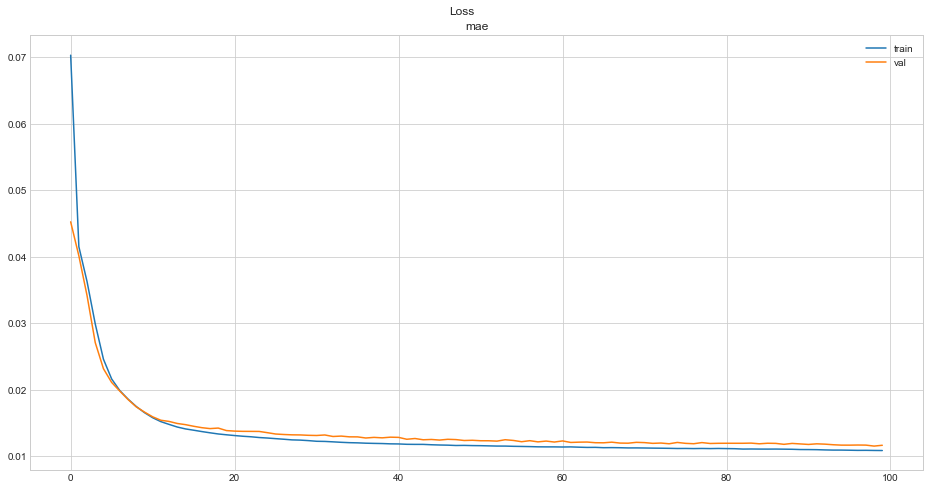

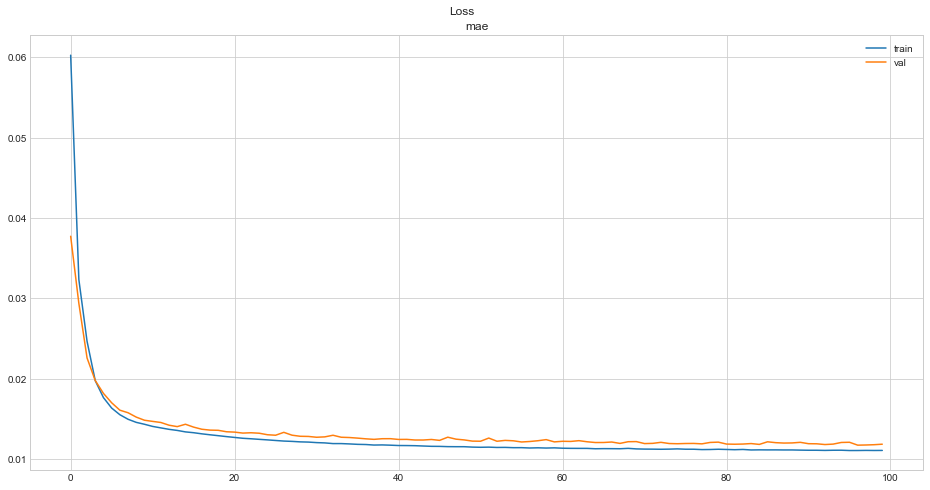

In [25]:
for train_index, val_index in kfold.split(data_X_feature):
    train_X, val_X = data_X_feature[train_index],data_X_feature[val_index]
    train_y, val_y = data_y_feature[train_index], data_y_feature[val_index]
    train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
    val_X = val_X.reshape(val_X.shape[0], 1, val_X.shape[1])
    
    model = make_model(train_X, train_y, ga_result)
    
     


In [36]:
model.save('./LN2/Cross_validation/4H.h5')